<center><h1>Statistics for Machine Learning</h1></center>
&nbsp;
<center><h2>Sampling a Distribution & Bessel's Correction</h2></center>

### Overview


### Pre-requisites

This notebook builds on *Population Parameters of Normal Distributions*, using the ideas of mean, variance and standard deviation to predict the population parameters of a dataset governed by a Normal distribution.

### Contents

Section 1 - Taking a Sample

Section 2 - Estimating Population Parameters

Section 3 - Deriving Bessel's Correction

Section 4 - Conclusion

Section 5 - Glossary

Section 6 - References

### Loading the Data

The SOCR dataset from UCLA contains height and weight information for 25,000 18 year olds, who form the population for this notebook.

In [2]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad

In [3]:
df = pd.read_csv('datasets/SOCR-HeightWeight.csv', sep=',')
heights = list(df['Height(Inches)'])
weights = list(df['Weight(Pounds)'])

heights.sort()
weights.sort()

print(f'Number of rows: {len(df)}')

Number of rows: 25000


<center><h2>Section 1 - Taking a Sample</h2></center>

### 1.1 - Motivation behind Sampling a Distribution

In the previous notebook *Population Parameters for Normal Distributions* the idea of a population was introduced. This is a set of all the possible entities we can take measurements from. In the example carried over from the last notebook, the population was a group of 25,000 individuals aged 18 years old. The two measurements made were the heights and weights for each individual.

Taking the height and weight measurements for 25,000 people is time-consuming, and can be very expensive. In experiments where the populations are much larger, such as finding the height and weight of every person in the UK, making a measurement for every item in the population becomes infeasible. In these cases, it would be much easier to take only a few measurements and try to predict the population parameters. These few measurements are called a **sample**.

### 1.2 - Choosing a Sample Size

A sample should be randomly taken from a population, this will avoid bias when choosing values (humans are notoriously bad at being random!). The larger the sample size, the more representative the data will be of the population. To illustrate this, the histograms for a few different sample sizes are plotted below.

For this notebook, a sample size of 100 people will be used to estimate the population parameters. This was chosen since it is a much more managable number of measurements to take, and still gives a good representation of the population. This corresponds to a 96% reduction in the measurements we need to take, which will save a lot of time of expense.

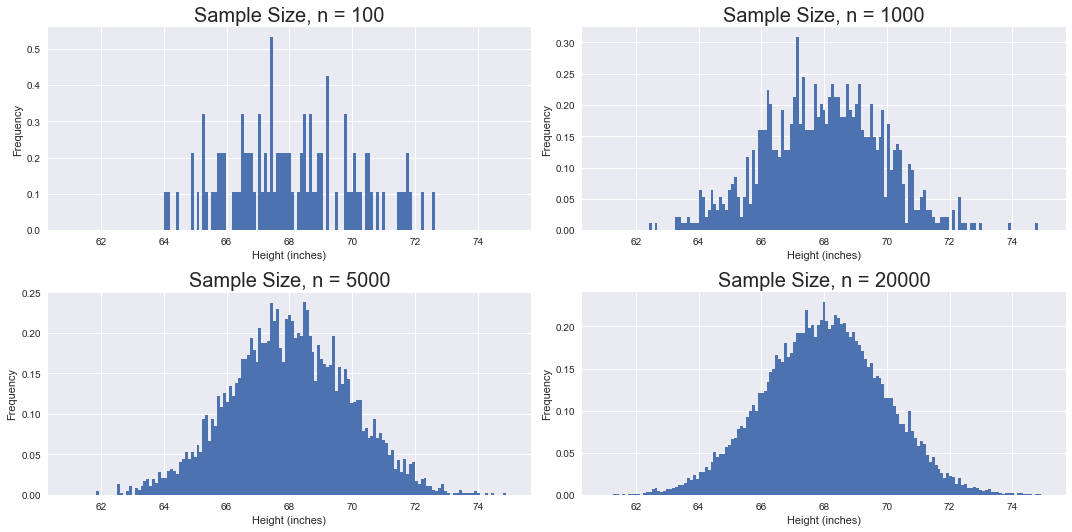

In [4]:
plt.style.use('seaborn')

# Plot the graphs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7.5))

for row, col, n in [(0,0,100), (0,1,1000), (1,0,5000), (1,1,20000)]:
        sample_heights = np.random.choice(heights, size=n, replace=False)
        ax[row][col].hist(sample_heights, bins=np.linspace(61,75,150), density=True)
        ax[row][col].set_title(f'Sample Size, n = {n}', fontsize=20)
        ax[row][col].set_xlabel('Height (inches)')
        ax[row][col].set_ylabel('Frequency')

fig.tight_layout()

# Set the sample size (n) to 1000
sample_heights = np.random.choice(heights, size=100, replace=False)
sample_weights = np.random.choice(weights, size=100, replace=False)

# Sort the samples - required for plotting
sample_heights.sort()
sample_weights.sort()

### 1.3 - Comparing the Sample and Population Data

Usually we don't have access to an entire population, which is why we take samples. However in this case we have the entire dataset, so we can compare the shapes of the population data ($N$=25,000) to the sample data ($n$=100). Note the difference in casing, $N$ refers to the size of an entire population, and $n$ refers to the sample size.

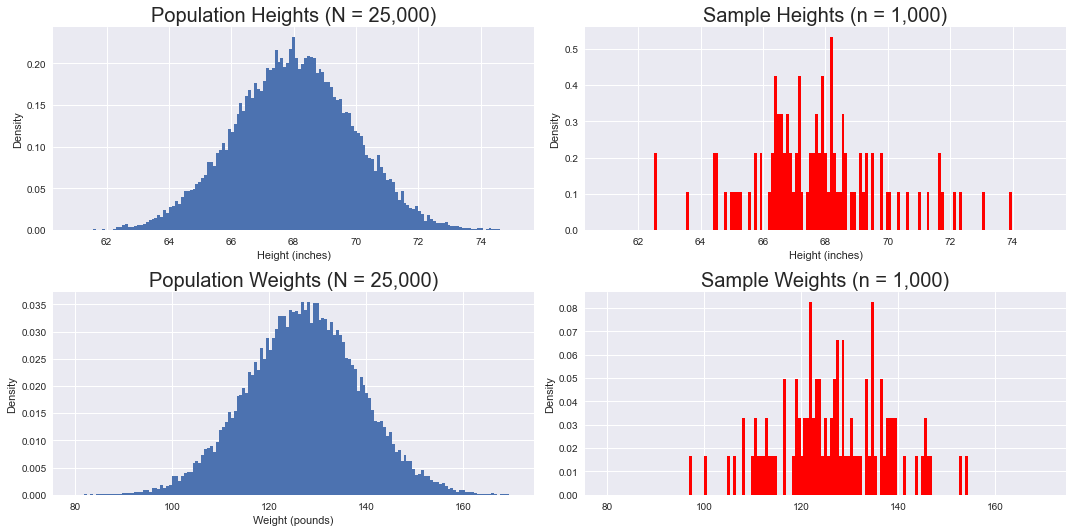

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7.5))

ax[0][0].set_title('Population Heights (N = 25,000)', fontsize=20)
ax[0][0].hist(heights, bins=np.linspace(61,75,150), density=True)

ax[0][1].set_title('Sample Heights (n = 1,000)', fontsize=20)
ax[0][1].hist(sample_heights, bins=np.linspace(61,75,150), color='red', density=True)

ax[1][0].set_title('Population Weights (N = 25,000)', fontsize=20)
ax[1][0].hist(weights, bins=np.linspace(80,170,150), density=True)

ax[1][1].set_title('Sample Weights (n = 1,000)', fontsize=20)
ax[1][1].hist(sample_weights, bins=np.linspace(80,170,150), color='red', density=True)

for row, col in [(0,0), (0,1), (1,0), (1,1)]:
    ax[0][col].set_xlabel('Height (inches)')
    ax[row][0].set_xlabel('Weight (pounds)')
    ax[row][col].set_ylabel('Density')

fig.tight_layout()

<center><h2>Section 2 - Estimating Population Parameters</h2></center>

### 2.1 - Calculating the Sample Mean

The sample mean is an estimate for the population mean based on the data we have. This might only be a small sample, so the sample mean could be quite different to the actual population mean. The more data we have the smaller the difference between the two, and the more confident we can be that the sample is representative of the entire population.

To find the sample mean, simply add each of the sample values together and divide by the number of sample values. This is exactly the same as the formula for the population mean - the key difference here is the notation.

To distinguish between population mean and sample mean, and population size and sample size, a couple of notation changes are made:

$
\bar{x} = \frac{\sum  \limits _{i=1}^{n} x_i}{n}
$

where $\bar{x}$ is the sample mean and $n$ is the sample size.

Compare this to the population mean:

$
μ = \frac{\sum  \limits _{i=1}^{N} x_i}{N}
$

&nbsp;

The sample means for heights and weights are calculated below - note how close the values are when using only a small fraction of the data!

In [6]:
def mean(values):
    return sum(values)/len(values)

# Sample Means
x_bar_heights = mean(sample_heights)
x_bar_weights = mean(sample_weights)

# Population Means
mu_heights = mean(heights)
mu_weights = mean(weights)

print(f'Mean sample height: {x_bar_heights:.2f} inches. This differs from the true mean by {abs(x_bar_heights-mu_heights):.2f} inches')

print(f'Mean sample weight: {x_bar_weights:.2f} pounds. This differs from the true mean by {abs(x_bar_weights-mu_weights):.2f} pounds')

Mean sample height: 67.71 inches. This differs from the true mean by 0.29 inches
Mean sample weight: 126.46 pounds. This differs from the true mean by 0.62 pounds


### 2.2 - Calculating the Sample Variance

Just how the sample mean is an estimate for the population mean based on a relatively small number of samples, the **sample variance** is an estimate of the population variance. The key difference here (aside from the notational changes described below), is the division by the sample size minus 1, and not simply the sample size. This is called **Bessel's correction**, and accounts for the fact that the sample variance always under estimates the true variance. The mathematical explanation for this is given later, but for now it is useful to see the formula written out in full. Also note that since we do not know the true mean, we will subtract the sample mean from each value of $x$ instead.

Again, a few notational changes are made to distinguish the sample variance from the population variance:

&nbsp;

$
s^2  = \frac{\sum  \limits _{i=1}^{n} (x_i - \bar{x})^2}{n-1}
$

&nbsp;

where $s^2$ is the sample variance, $\bar{x}$ is the sample mean and $n$ is the sample size.

Compare this to the population variance:

&nbsp;

$
\sigma^2  = \frac{\sum  \limits _{i=1}^{N} (x_i - \mu)^2}{N}
$

&nbsp;

The sample variances for heights and weights are calculated below. Again, note how close the values to the population variances.

In [7]:
def variance(values, is_population=True):
    mu = mean(values)
    N = len(values)
    if is_population:
        return sum([(x-mu)**2 for x in values]) / N
    else:
        return sum([(x-mu)**2 for x in values]) / (N-1)

s_squared_heights = variance(sample_heights, is_population=False)
s_squared_weights = variance(sample_weights, is_population=False)

sigma_squared_heights = variance(heights)
sigma_squared_weights = variance(weights)

print(f'Variance of sample height: {s_squared_heights:.2f} inches^2.')
print(f'This differs from the true variance by {abs(s_squared_heights-sigma_squared_heights):.2f} inches^2.\n')
print(f'Variance of sample weight: {s_squared_weights:.2f} pounds^2.')
print(f'This differs from the true variance by {abs(s_squared_weights-sigma_squared_weights):.2f} pounds^2.')

Variance of sample height: 4.43 inches^2.
This differs from the true variance by 0.82 inches^2.

Variance of sample weight: 127.10 pounds^2.
This differs from the true variance by 8.87 pounds^2.


### 2.3 - Calculating the Sample Standard Deviation

The **sample standard deviation** is simply calculated by taking the square root of the sample variance. For completeness, the equation for the sample standard deviation is shown alongside the population standard deviation.

&nbsp;

$
s = \sqrt{\frac{\sum  \limits _{i=1}^{n} (x_i - \bar{x})^2}{n-1}}
$

&nbsp;

where $s$ is the sample standard deviation, $\bar{x}$ is the sample mean and $n$ is the sample size.

Compare this to the population standard deviation:

&nbsp;

$
σ = \sqrt{\frac{\sum  \limits _{i=1}^{N} (x_i - \mu)^2}{N}}
$

&nbsp;

Finally, the sample standard deviation for the heights and weights is calculated below, and compared to the population standard deviations.

In [8]:
def stdev(values, is_population=True):
    return math.sqrt(variance(values, is_population))


s_heights = stdev(sample_heights, is_population=False)
s_weights = stdev(sample_weights, is_population=False)

sigma_heights = stdev(heights)
sigma_weights = stdev(weights)


print(f'Standard deviation of sample height: {s_heights:.2f} inches')
print(f'This differs from the true standard deviation by {abs(s_heights-sigma_heights):.2f} inches.\n')
print(f'Standard deviation of sample weight: {s_weights:.2f} pounds')
print(f'This differs from the true standard deviation by {abs(s_weights-sigma_weights):.2f} pounds.')

Standard deviation of sample height: 2.11 inches
This differs from the true standard deviation by 0.20 inches.

Standard deviation of sample weight: 11.27 pounds
This differs from the true standard deviation by 0.39 pounds.


### 2.4 - Generating a Curve from the Normal Probability Density Function

Now that we have estimates for the population parameters $\mu$ and $\sigma$ in the form of $\bar{x}$ and $s$ respectively, we can estimate the Normal distribution curve for the heights and weights. This gives a way to visualise the population and predict probabilities without measuring every single person in the population.

Below, the Normal curves have been plot as before in *Population Parameters for Normal Distributions*, with the population curve shown in blue, and the estimate made using the sample data in red.

In [9]:
def normal(x_values, is_population=True):
    mu = mean(x_values)
    sigma = stdev(x_values, is_population=is_population)

    return [(1/(sigma*math.sqrt(2*math.pi))) * math.e**(-1*(((x-mu)**2)/(2*(sigma**2)))) for x in x_values]

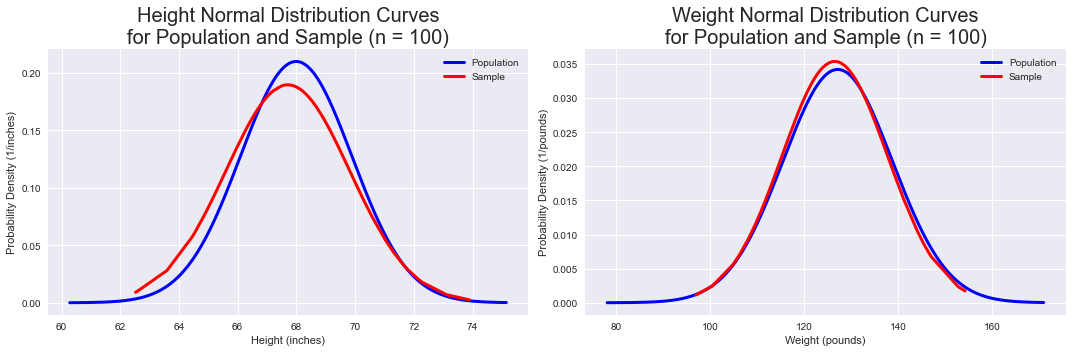

In [10]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].set_title('Height Normal Distribution Curves\nfor Population and Sample (n = 100)', fontsize=20)
ax[0].set_xlabel('Height (inches)')
ax[0].set_ylabel('Probability Density (1/inches)')
ax[0].plot(heights, normal(heights), color='blue', linewidth=3, label='Population')
ax[0].plot(sample_heights, normal(sample_heights, is_population=False), color='red', linewidth=3, label='Sample')
ax[0].legend()

ax[1].set_title('Weight Normal Distribution Curves\nfor Population and Sample (n = 100)', fontsize=20)
ax[1].set_xlabel('Weight (pounds)')
ax[1].set_ylabel('Probability Density (1/pounds)')
ax[1].plot(weights, normal(weights), color='blue', linewidth=3, label='Population')
ax[1].plot(sample_weights, normal(sample_weights, is_population=False), color='red', linewidth=3, label='Sample')
ax[1].legend()

fig.tight_layout()

### 2.5 - Reflecting on the Estimated Curves

Using a sample of 100 heights and weights produced curves that match the population data fairly well, especially given this represents just 0.4% of the total data. For some cases however this accuracy might not be enough, and so it is useful to explore other sample sizes. Below is the estimated curve using a sample size of 1,000, which represents 4% of the total data. Note how even with just 4%, the accuracy is very high.

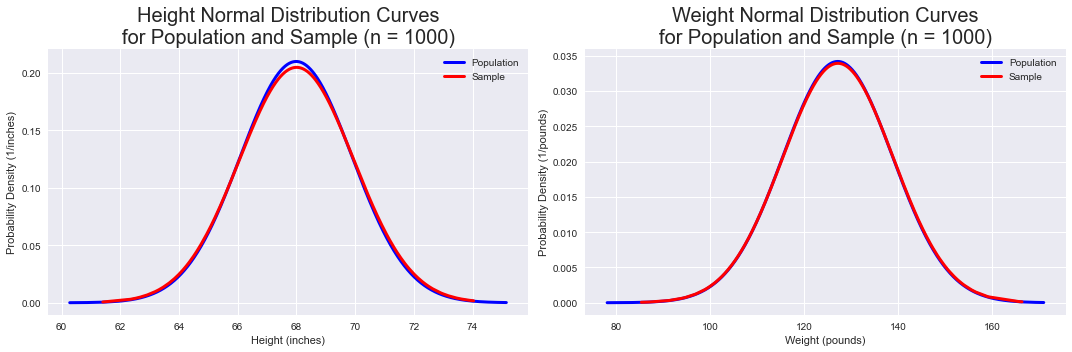

In [11]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sample_heights = np.random.choice(heights, size=1000, replace=False)
sample_weights = np.random.choice(weights, size=1000, replace=False)
sample_heights.sort()
sample_weights.sort()

ax[0].set_title('Height Normal Distribution Curves\nfor Population and Sample (n = 1000)', fontsize=20)
ax[0].set_xlabel('Height (inches)')
ax[0].set_ylabel('Probability Density (1/inches)')
ax[0].plot(heights, normal(heights), color='blue', linewidth=3, label='Population')
ax[0].plot(sample_heights, normal(sample_heights, is_population=False), color='red', linewidth=3, label='Sample')
ax[0].legend()

ax[1].set_title('Weight Normal Distribution Curves\nfor Population and Sample (n = 1000)', fontsize=20)
ax[1].set_xlabel('Weight (pounds)')
ax[1].set_ylabel('Probability Density (1/pounds)')
ax[1].plot(weights, normal(weights), color='blue', linewidth=3, label='Population')
ax[1].plot(sample_weights, normal(sample_weights, is_population=False), color='red', linewidth=3, label='Sample')
ax[1].legend()

fig.tight_layout()

<center><h2>Section 3 - Deriving Bessel's Correction</h2></center>

### 3.1 - Why is a Correction Needed?

In the previous section it was stated that the sample variance is calculated by taking the sum of the squared differences divided by the sample size minus 1, $n-1$, rather than just the sample size, $n$. This is different to the population variance, where the sum of the squared differences is divivded by the just the population size, $N$. The reason given for this was that the sample variance underestimates the population variance. But why is this the case? This will be explained in three steps: first a written overview, second a visual example, and finally a mathmematical proof.

### 3.2 - Bessel's Correction: Written Overview

The sample variance uses the squared distance between every measurement and the **sample mean** - this is because the true (population) mean is unknown. The squared differences between each of the samples and any other number, will be the smallest when the number is the average of the samples. This is because the average of the samples will be the point that minimises the distance between itself and every sample. Since the true mean is very rarely the sample mean, most of the time the squared differences will be lower - leading to an underestimate of the variance.

### 3.3 - Bessel's Correction: Visual Explanation

To show this visually, a few plots have been drawn. These show a number line with some sample points (blue), and a random point (red). If we find the sum of the squared distances between the samples and the random point, $v$, we can see that this value will be at a lowest when the random point is the average of the samples.

The sample points used are:
(1,0)
(2,0)
(3,0)
(6,0)
(8,0)
</p>

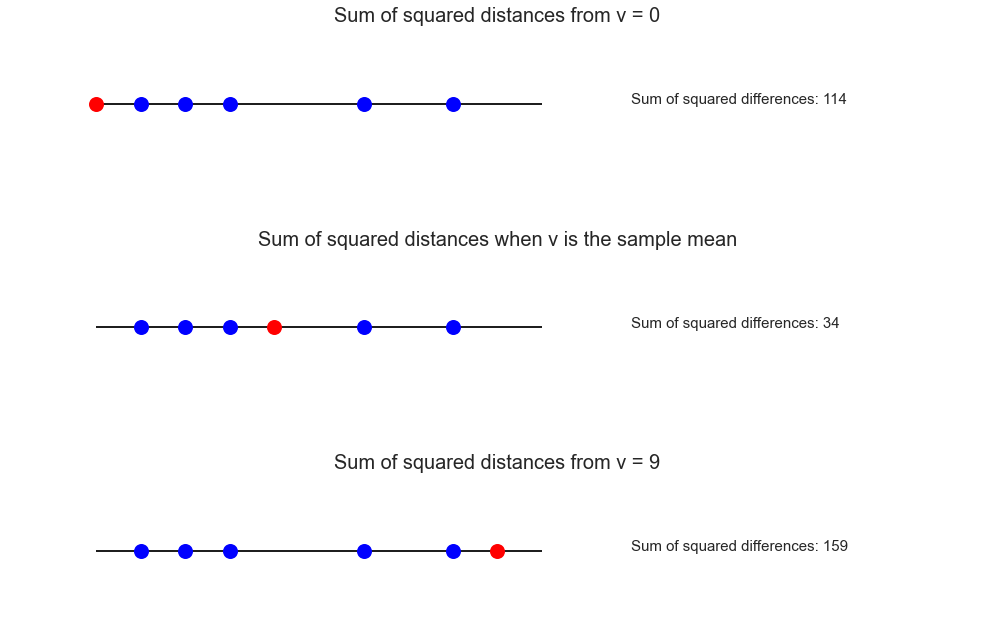

In [17]:
def sum_square_diff(values, point):
    return sum([(value-point)**2 for value in values])

fig, ax = plt.subplots(nrows=3, figsize=(15,10))

sample_points = [(1,0), (2,0), (3,0), (6,0), (8,0)]
sample_x = [coords[0] for coords in sample_points]
point_x = [0, 4, 9]

for i in range(3):
    ax[i].set_xlim(-2,20)
    ax[i].set_ylim(-5,5)

    if point_x[i] == 4:
        ax[i].set_title('Sum of squared distances when v is the sample mean', fontsize=20)
    else:
        ax[i].set_title(f'Sum of squared distances from v = {point_x[i]}', fontsize=20)

    ax[i].hlines(0, 0, 10, color='black')
    for p in sample_points:
        ax[i].plot(p[0], p[1], 'o', markersize = 15, markerfacecolor = 'b')
    ax[i].plot(point_x[i], 0, 'o', markersize = 15, markerfacecolor = 'red')
    ax[i].text(12, 0, f'Sum of squared differences: {sum_square_diff(sample_x, point_x[i])}', fontsize=15)
    ax[i].axis('off')

fig.tight_layout(pad=5)

We can plot how the sum of the squared differences will change on a graph. This will use the $x$-axis to plot $v$ which will be the point from which the squared distance is found for every point in the sample. The minimum point of this curve will be the value of $v$ that gives the lowest sum of squared values, which occurs when $v$ = $\bar{x}$. 

Text(0.7, 0.5, 'Population Mean')

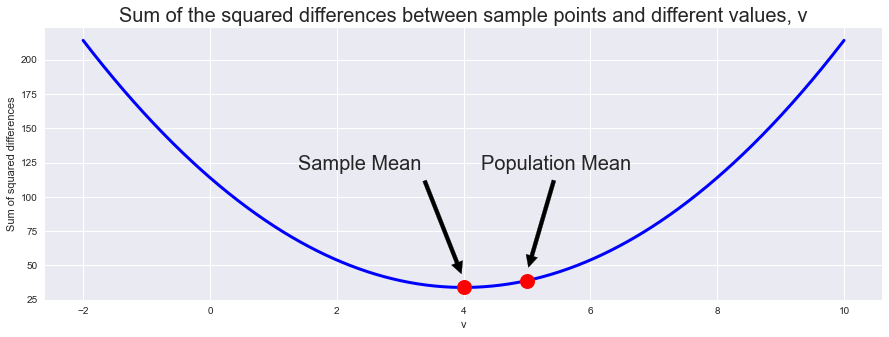

In [18]:
fig, ax =plt.subplots(figsize=(15,5))

v = np.linspace(-2, 10, 1000)

ax.set_title('Sum of the squared differences between sample points and different values, v', fontsize=20)
ax.set_xlabel('v')
ax.set_ylabel('Sum of squared differences')
ax.plot(v, sum_square_diff(sample_x, v), color='blue', linewidth=3)
ax.plot(mean(sample_x), sum_square_diff(sample_x, mean(sample_x)), color='red', marker='o', markersize=15, linewidth=3)
ax.plot(5, sum_square_diff(sample_x, 5), color='red', marker='o', markersize=15, linewidth=3)

ax.annotate('Sample Mean', 
            xy=(4, 40),
            xycoords='data',
            xytext=(0.45, 0.5), 
            fontsize=20,
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment='center')

ax.annotate('Population Mean', 
            xy=(5, 45),
            xycoords='data',
            xytext=(0.7, 0.5), 
            fontsize=20,
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment='center')

### 3.4 - Bessel's Correction: Mathematical Proof

The following mathematical proof is broken into two parts: one the show that the sample mean will always give the smallest sum of the squared differences, and one to show why dividing by $n-1$ will correct for this.

&nbsp;


<h3 align="center">Proof 1: The sample mean always gives the smallest sum of square differences</h3>


**Step 1)** We can write the equation for variance using a variable number, $v$, from which the squared differences are calculated. This is the equation of the curve shown in the figure above.
&nbsp;
$
\frac{\sum \limits_{i=1}^{n}(x_i-v)^2}{n} \tag{1}
$
&nbsp;

**Step 2)** Differentiating this curve gives an expression for the gradient, which equals 0 at the minimum point of the curve (where the sum of the squared differences is minimised). We can set the derivative equal to 0 and solve for $v$ to find the value that causes the minimum sum of squared difference.
$
\frac{d}{dv} \frac{\sum \limits_{i=1}^{n}(x_i-v)^2}{n} = 0 \tag{2}
$
&nbsp;

**Step 3)** Rearranging this equation and solving for $v$ gives:

$
\frac{\sum \limits_{i=1}^{n}-2(x_i-v)}{n} = 0 \tag{3}
$
&nbsp;
$
-2 \times \frac{\sum \limits_{i=1}^{n}(x_i-v)}{n} = 0  \tag{4}
$
&nbsp;
$
\frac{\sum \limits_{i=1}^{n}(x_i-v)}{n} = 0 \tag{5}
$
&nbsp;
$
\frac{\sum \limits_{i=1}^{n}(x_i)}{n} + \frac{\sum \limits_{i=1}^{n}(-v)}{n}= 0 \tag{6}
$
&nbsp;

**Step 4)** Note that the first term on the left is the average of the samples, $\bar{x}$ , and the second term is simply $v$ since the sum of $v$ $n$ times divided by $n$ cancels to just $v$.


$
\frac{\sum \limits_{i=1}^{n}(x_i)}{n} - \frac{\sum \limits_{i=1}^{n}(v)}{n}= 0 \tag{7}
$
&nbsp;
$
\bar{x} - v = 0 \tag{8}
$
&nbsp;

**Step 5)** Taking the negative $v$ to the right hand side confirms the result presented in the graphical representation:
&nbsp;
$
v = \bar{x} \tag{9}
$

<h3 align="center">Proof 2: Why dividing by n-1 corrects the sample variance</h3>

This proof is adapted from Gregory Gundersen [4], who gives a brilliant, simple derivation for Bessel's correction. See the link to his blog for the full post, which covers some extra useful details. Below is my adaptation of this proof, with some additional comments to aid with understanding.

&nbsp;

**Step 1)** Write the equation for the sample standard deviation, which is calculated using the sample mean, $\bar{x}$.   
$
s^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2
$
&nbsp;

**Step 2)** Take the expected value of the equation and expand the squared term. This will allow us to perform some manipulations on the right hand side, and prove that it is still equal to the expected value of the standard deviation on the left hand side.
&nbsp;
$
\mathbb{E}\Big[\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2\Big] = \mathbb{E}\Big[\frac{1}{n} \sum_{i=1}^{n} (x_i^2 - 2 x_i \bar{x} + \bar{x}^2) \Big] \tag{1}
$
&nbsp;

**Step 3)** Use the fact that summations can be distributed to continue manipulating the right hand side.
&nbsp;
$
=\mathbb{E}\Big[\frac{1}{n} \sum_{i=1}^{n} x_i^2 - 2 \bar{x} \frac{1}{n} \sum_{i=1}^{n} x_i + \frac{1}{n} \sum_{i=1}^{n} \bar{x}^2 \Big] \tag{2}
$
&nbsp;

**Step 4)** The expected value of multiple terms added together is equal to the sum of the expected value of those terms individually. Note that the summation in second term is divided by $n$, and so the sum of all the samples divided by the sample size will give the sample mean. Hence, we can replace the summation divided by $n$ with $\bar{x}$.
&nbsp;
$
=\mathbb{E}\Big[\frac{1}{n} \sum_{i=1}^{n} x_i^2 \Big] - \mathbb{E}\big[2 \bar{x}^2\big] + \mathbb{E}\big[\bar{x}^2 \big] \tag{3}
$
&nbsp;

**Step 5)** Perform the subtraction for the second and third terms.
&nbsp;
$
=\mathbb{E}\Big[\frac{1}{n} \sum_{i=1}^{n} x_i^2\Big] - \mathbb{E}\big[\bar{x}^2 \big] \tag{4}
$
&nbsp;

**Step 6)** The first term can be rewritten to take the summation to the outside, which just leaves an average of the expected value of $x^2$, which is simply the expected value of $x^2$. This is true because the expected value of any variable will be a constant, and so adding it to itself $n$ times then dividing by $n$ will return the original value. We can state this because the data are **independent and identically distributed** (each sample value drawn from the population does not depend on the other values, that is they are independent, and are all governed by the same normal distribution, that is they are identically distributed).
&nbsp;

$
\mathbb{E}\Big[\frac{1}{n} \sum_{i=1}^{n} x_i^2 \big] = \frac{1}{n} \sum_{i=1}^{n} \mathbb{E}\big[ x_i^2 \big] = \mathbb{E}\big[ x_i^2 \big].
$
Hence
$
=\mathbb{E}\big[ x_i^2 \big] - \mathbb{E} \big[ \bar{x}^2 \big] \tag{5}
$

&nbsp;

**Step 7)** Now we have an expression for the sample variance in terms of the expected values of $x$ and $\bar{x}$. We can compare this to a well known expression for variance in terms of expected values. Variance can be written as:
&nbsp;
$
\text{Var}(X) = \mathbb{E}[X^2] - \mathbb{E}[X]^2 \quad\implies\quad \mathbb{E}[X^2] = \text{Var}(X) + \mathbb{E}[X]^2.
$

&nbsp;

Knowing this, we can compare our expression from (5) find the below equation. Note that the expected value of $x$ is $\mu$ since this is the average value you would expect to see after enough observations.

$
\mathbb{E}\big[ x_i^2 \big] = \text{Var}(x_i) + \mathbb{E}[x_i]^2 =\sigma^2 + \mu^2
$
&nbsp;


We can now rewrite the first term in (5) in terms of $\sigma$ and $\mu$, so let's now turn our attention to the second term of (5). Using the same relationship, we can write the following equation:
&nbsp;

$
\mathbb{E} \big[ \bar{x}^2 \big] = \text{Var}(\bar{x}) + \mathbb{E}[\bar{x}]^2
$
&nbsp;

We already know that $\mathbb{E}[\bar{x}]^2$ simplifies to $\mu^2$, but what about $\text{Var}(\bar{x})$? For this we can write out $\bar{x}$ in full and manipulate the expression:


$
\text{Var}(\bar{x}) = \text{Var}\big(\frac{1}{n} \sum_{i=1}^{n} x_i \big)
$

$
=\frac{1}{n^2} \sum_{i=1}^{n} \text{Var}(x_i)
$

$
\frac{1}{n^2} \sum_{i=1}^{n} \sigma^2
$

&nbsp;

Note that the variance summed $n$ times then divided by $n^2$ gives the variance divided by just $n$, and so:

$
\text{Var}(\bar{x}) = \frac{\sigma^2}{n}.
$

&nbsp;

Finally, this gives:

$
\mathbb{E} \big[ \bar{x}^2 \big] = \text{Var}(\bar{x}) + \mathbb{E}[\bar{x}]^2 = \frac{\sigma^2}{n} + \mu^2. \tag{6}
$

&nbsp;


**Step 8)** Combine the results in found in Step 7 with (5) to obtain the following:

$
\mathbb{E}[s^2] = \sigma^2 + \mu^2 - \Big(\frac{\sigma^2}{N} + \mu^2\Big)
$

&nbsp;

**Step 9)** Factorise and simplify:

$
\mathbb{E}[s^2] = \sigma^2 \Big(1 - \frac{1}{N} \Big). \tag{3}
$

&nbsp;

**Step 10)** Now we've proven that the sample standard deviation is difference from the population standard deviation. In technical terms we say that the estimator is **biased**. The amount the estimate is biased by is given by $(1-\frac{1}{n})$, which can be written as $(\frac{n-1}{n})$. To account for this bias, we can multiply the sample variance by the inverse of this fraction. Note that the $n$ in the numerator of the correction cancels out the $n$ in the denominator of the sample variance, giving just a division of $n-1$ for the correction.

$
\mathbb{E}\Big[\big(\frac{n}{n-1}\big) s^2\Big] = \mathbb{E}\Big[\frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2\Big] = \sigma^2.
$

&nbsp;

<center><h2>Section 4 - Conclusion</h2></center>

This notebook introduced sampling a distribution, and the motivations for estimating population parameters using just a small subset of measurements. The formulae needed for this were also shown, including the correction needed for the sample variance, which was later derived. These equations are very useful in the field of statistics, and are applied much more often than those for calculating population parameters, since we rarely have all the data for an entire population. Future notebooks will build on these concepts to cover more advanced statistics topics.

<center><h2>Section 5 - Glossary</h2></center>

**Bessel's Correction**
> A factor used to account for the fact that the sample variance and sample standard deviation always underestimate the population variance and standard deviation

**Independent and Identically Distributed**
> The term for a random variable where the value of each measurement does not depend on the other measurements, and where each measurement is governed by the same distribution

**Sample**
> A subset of measurements from a population, usually used to estimate the population parameters without taking a large amount of measurements

**Sample Mean**
> An estimation of the population mean using the avereage value of a number of samples

**Sample Standard Deviation**
> The standard deviation of some samples from a population used to estimate the population standard deviation, this is corrected for used Bessel's correction

**Sample Variance**
> The variance of some samples from a population used to estimate the population variance, this is corrected for used Bessel's correction

<center><h2>Section 6 - References</h2></center>

[1] Dataset background and download - [Kaggle](https://www.kaggle.com/burnoutminer/heights-and-weights-dataset/version/1)

[2] Calculating variance with the absolute differences - [Stephen Gorard](https://emilkirkegaard.dk/en/wp-content/uploads/Revisiting-a-90-year-old-debate-the-advantages-of-the-mean-deviation.pdf)

[3] Derivation of the Normal Distribution Equation - [YouTube](https://www.youtube.com/watch?v=cTyPuZ9-JZ0)

[4] Derivation of Bessel's Correction - [Gregory Gundersen](https://gregorygundersen.com/blog/2019/01/11/bessel/)